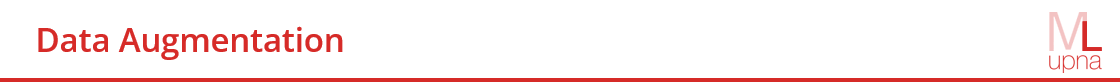

In this exercise, you will learn how to improve the performance of computer vision models through <span style="color:#D52B29">image data augmentation</span>.

Instead of collecting huge amounts of new data, we will generate <span style="color:#D52B29">new variations</span> of existing images to help models generalize better and become more robust to real-world conditions. We will explore different families of <span style="color:#D52B29">augmentation techniques</span>:

- <span style="color:#D52B29">Geometric transformations</span> – such as flips, rotations, crops, and perspective changes, to simulate different viewpoints and object positions.

- <span style="color:#D52B29">Photometric transformations</span> – including brightness, contrast, and color jitter, to mimic changes in lighting or camera conditions.

- <span style="color:#D52B29">Advanced strategies</span> – such as CutOut, MixUp, and CutMix, which go beyond single-image transformations by altering or combining multiple images.

By the end of this practice, you will understand how <span style="color:#D52B29">data augmentation</span> reduces overfitting, enhances robustness, and allows training strong models even with limited data.

For this purpose, we will work with the <span style="color:#D52B29">CIFAR-10 dataset</span>, already introduced in previous practices. It contains 60,000 color images of size 32×32 pixels, distributed across 10 classes.

All transformations will be implemented using the <span style="color:#D52B29">torchvision.transforms</span> library, which provides a wide variety of augmentation functions ready to use in PyTorch pipelines.

We will start by loading the <span style="color:#D52B29">dataset</span> and applying two basic transformations:

- <span style="color:#D52B29">Normalize</span>, using the dataset’s mean and standard deviation.

- <span style="color:#D52B29">ToTensor</span>, to convert the images into PyTorch tensors.

For simplicity, we will only take the <span style="color:#D52B29">first six examples</span> from the dataset.

Next, we will define a function <code>show_batch()</code> that will take a <span style="color:#D52B29">DataLoader</span> and display the augmented examples, repeating the process as many times as specified by the <code>repetitions</code> parameter.

In [8]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights

import pytorch_lightning as pl
from lightning.pytorch.loggers import CSVLogger
from pytorch_lightning import LightningModule

In [17]:
class CassavaDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"])
        image = Image.open(img_path).convert("RGB")
        label = int(row["label"])
        if self.transform:
            image = self.transform(image)
        return image, label


class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, csv_path, json_path, transform, batch_size=64, num_workers=2):
        super().__init__()
        self.data_dir = data_dir
        self.csv_path = csv_path
        self.json_path = json_path
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Transforms (standard ImageNet normalization)
        self.val_transform = transforms.Compose([
            transforms.Resize(256),               # Resize smaller edge to 256 (keeps aspect ratio)
            transforms.CenterCrop(224),           # Crop the center 224x224 region
            transforms.ToTensor(),                # Convert to tensor (HWC → CHW, scales to [0,1])
            transforms.Normalize(                 # Normalize with ImageNet mean and std
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        self.train_transform = transform


    def setup(self, stage=None):
        # Load metadata
        df = pd.read_csv(self.csv_path)
        with open(self.json_path, "r") as f:
            self.class_mapping = json.load(f)

        # Split according to 'set' column
        train_df = df[df["set"] == "train"]
        val_df = df[df["set"] == "val"]
        test_df = df[df["set"] == "test"]

        # Create datasets
        self.train_ds = CassavaDataset(train_df, os.path.join(self.data_dir, "images"), transform=self.train_transform)
        self.val_ds = CassavaDataset(val_df, os.path.join(self.data_dir, "images"), transform=self.val_transform)
        self.test_ds = CassavaDataset(test_df, os.path.join(self.data_dir, "images"), transform=self.val_transform)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

## Tools

In [ ]:
from lightning.pytorch.loggers import CSVLogger

# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Instantiate the model, freeze all layers and adapt the first layer
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) 

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for our specific task (e.g., 10 classes)
num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

# Wrap the model inside a LightningModule.
lightning_module = LightningModule(model)

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_resnet18_tl_feature_extractor_ok_tfms")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = CassavaDataModule(num_workers=4)

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

In [ ]:
import pandas as pd

metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first() # Group by epoch and take the first non-NaN for each column
metric_df.head()

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

In [ ]:
# Load the best model. Note that we need to include all the LightningMNISTClassifier's __init__ parameters
model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0) # Move to GPU

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_trues, y_hats = [], []

for (x, y_true) in iter(data_module.test_dataloader()):
    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = y_hat_logits.argmax(dim=1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true.cpu())

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f}')

# ✅ Get class labels
class_labels = list(data_module.class_mapping.values())

# ✅ Normalized confusion matrix
cm = confusion_matrix(
    y_trues,
    y_hats,
    labels=range(len(class_labels)),
    normalize='true'  # Normalizes each row (i.e., per true class)
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [18]:
def show_batch(dl, n_cols=6, repetitions=1):
    # ImageNet normalization (used by ResNet18_Weights.IMAGENET1K_V1)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for rep in range(repetitions):
        data, target = next(iter(dl))
        
        bs = data.shape[0]
        n_rows = int(np.ceil(bs / n_cols))
        
        f, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
        ax = ax.ravel()

        for i in range(bs):
            # Undo normalization for display
            img = data[i].permute(1, 2, 0).numpy()
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            ax[i].imshow(img)
            ax[i].set_title(str(target[i].item()))
            ax[i].set_xticks([])
            ax[i].set_yticks([])

        # Remove empty subplots
        for i in range(bs, n_rows * n_cols):
            f.delaxes(ax[i])
            
        plt.tight_layout()
        plt.show()


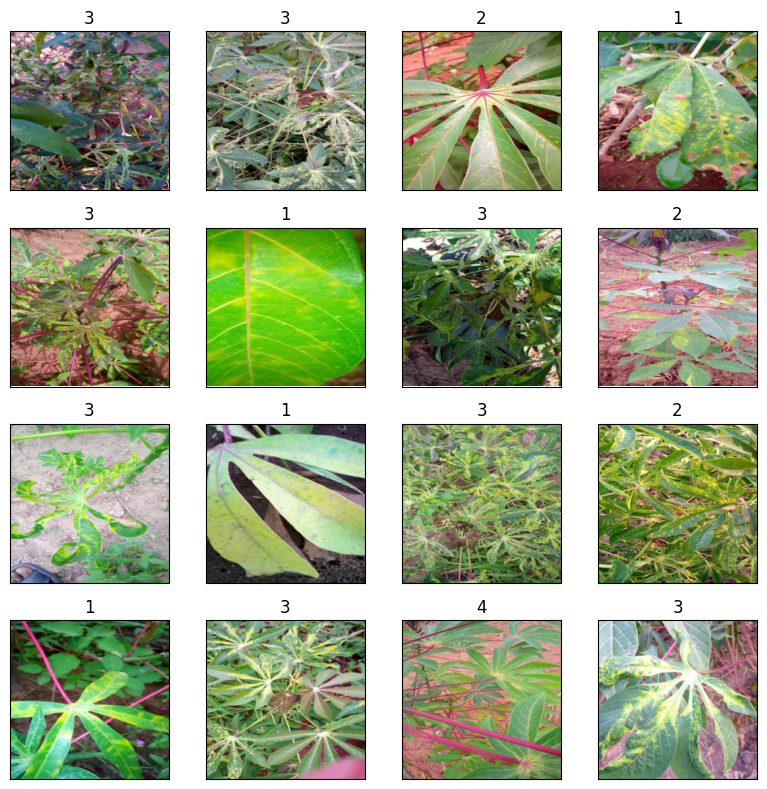

In [21]:
# Example paths — update these for your system
data_transform = transforms.Compose([
            transforms.Resize(256),               # Resize smaller edge to 256 (keeps aspect ratio)
            transforms.CenterCrop(224),           # Crop the center 224x224 region
            transforms.ToTensor(),                # Convert to tensor (HWC → CHW, scales to [0,1])
            transforms.Normalize(                 # Normalize with ImageNet mean and std
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

dm = CassavaDataModule(
    data_dir="cassava",
    csv_path="cassava/cassava_split.csv",
    json_path="cassava/label_num_to_disease_map.json",
    transform = data_transform,
    batch_size=16
)
dm.setup()

# Get a training dataloader
dl = dm.train_dataloader()

# Show a batch of images
show_batch(dl, n_cols=4, repetitions=1)

## Experimentation

## <span style="color:#D52B29">Geometric Transformations</span>

Geometric transformations are the most intuitive type of <span style="color:#D52B29">data augmentation</span>. They modify the spatial arrangement of pixels in an image without altering its content.

The goal is to help models recognize objects regardless of their orientation, position, or perspective. For example, a car remains a car whether it is slightly rotated, shifted, or mirrored.

In this subsection, we will explore some of the most common geometric transformations:

- <span style="color:#D52B29">Flipping</span> – mirrors an image horizontally or vertically.

- <span style="color:#D52B29">Rotation</span> – changes the angle of the object.

- <span style="color:#D52B29">Translation</span> – shifts the image along the x or y axis.

- <span style="color:#D52B29">Cropping and Resizing</span> – simulates zooming in or viewing objects at different distances.

- <span style="color:#D52B29">Shearing</span> – slants the image, mimicking a tilted perspective.

By applying these transformations, CNNs become more robust to real-world variations where objects rarely appear perfectly centered and aligned.


##### <span style="color:#D52B29">Flipping</span>

Flipping is a simple yet effective <span style="color:#D52B29">geometric transformation</span> that mirrors an image along a specific axis, helping the model recognize objects regardless of their orientation.

<span style="color:#D52B29">`RandomHorizontalFlip(p=0.5)`</span> 

- Mirrors the image horizontally with probability `p` (default 0.5). 
- This is commonly used to simulate objects appearing in different left-right orientations.

<span style="color:#D52B29">`RandomVerticalFlip(p=0.5)`</span>

- Mirrors the image vertically with probability `p`.
- This is less common but can be useful when objects may appear upside-down.

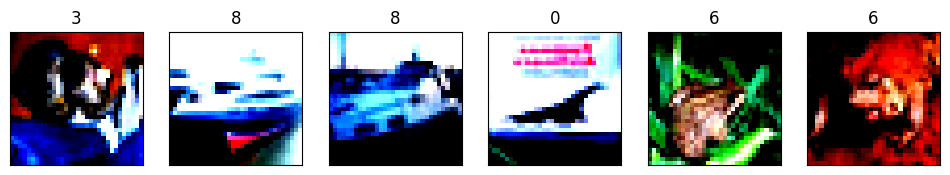

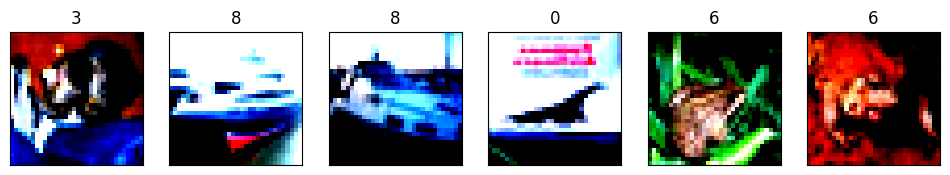

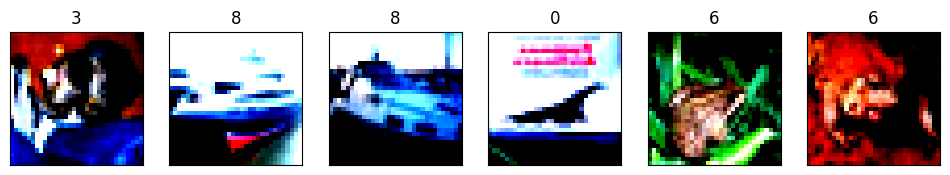

In [119]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(p=0.5)
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

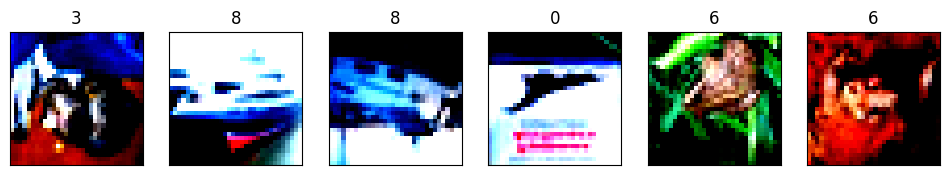

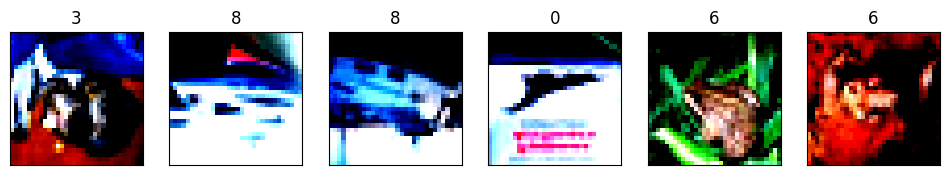

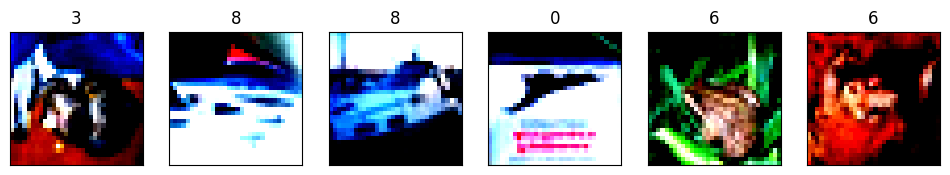

In [120]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomVerticalFlip(p=0.5)
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

It is also possible to apply both <span style="color:#D52B29">transformations</span> at the same time.

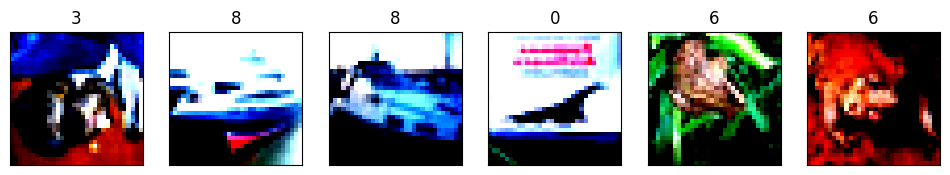

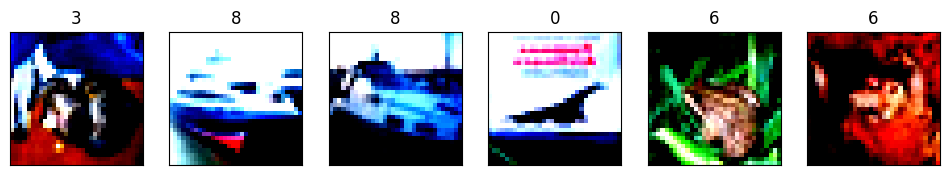

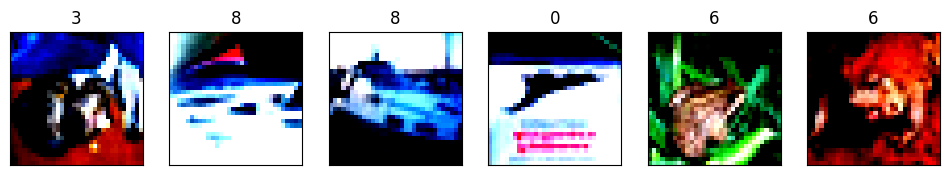

In [50]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5)
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

##### <span style="color:#D52B29">Rotation</span>

Rotation changes the angle of an image, helping the model recognize objects from multiple viewpoints.

<span style="color:#D52B29">`RandomRotation(degrees)`</span> 

- Rotates the image randomly within the range specified by `degrees`.  
- For example, `RandomRotation(45)` rotates images between -45° and 45°.  
- This helps CNNs become robust to tilted or angled objects in real-world images.

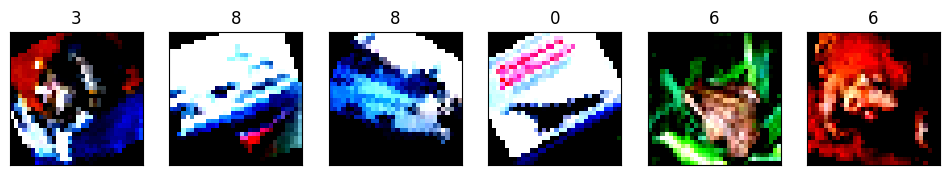

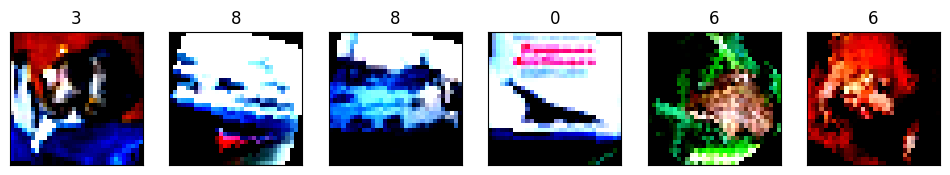

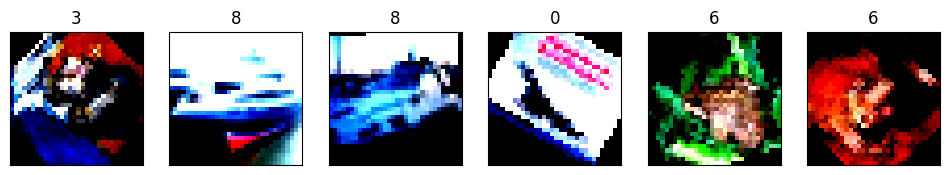

In [51]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomRotation(degrees=45)
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

If we want the image to randomly rotate by a specific angle, we need to define <span style="color:#D52B29">RandomRotation(degrees=(45, 45))</span> or <span style="color:#D52B29">RandomRotation(degrees=(90, 90))</span>. For example, if we want all possible rotations of 90 degrees, we need to apply a <span style="color:#D52B29">RandomChoice(list_of_augmentations)</span>.

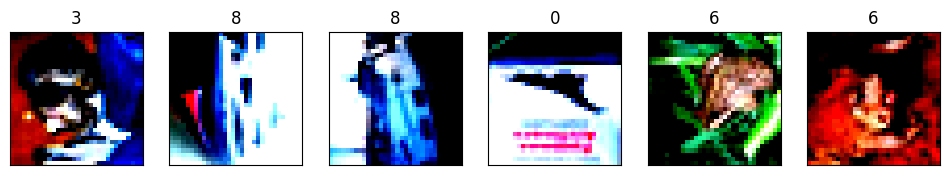

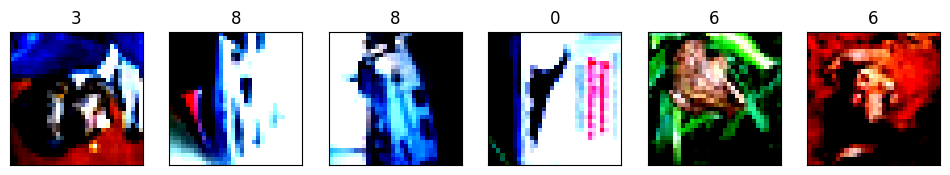

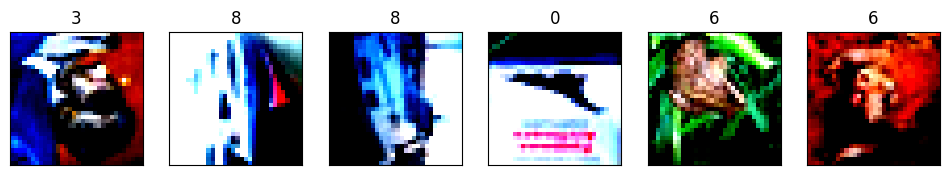

In [121]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomChoice([transforms.RandomRotation(degrees=(deg, deg)) for deg in [90, 180, 270]])
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

##### <span style="color:#D52B29">Dihedral</span>

Combining flipping with rotation transformations is often called a <span style="color:#D52B29">dihedral transformation</span>.  

- This generates all possible rotations and reflections of an image (like the symmetries of a square).  
- Dihedral augmentation can significantly improve robustness for objects appearing in multiple orientations.


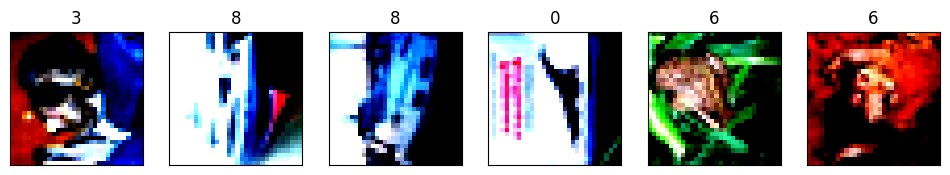

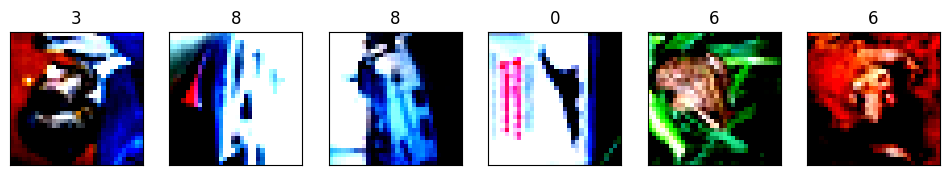

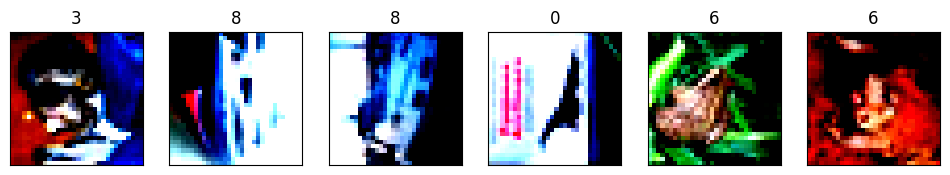

In [122]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=(90, 90))
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

##### <span style="color:#D52B29">Cropping and Resizing</span>

Cropping and resizing simulate changes in object scale and viewpoint, allowing the model to focus on different parts of the image or handle objects at various distances.

<span style="color:#D52B29">`RandomResizedCrop(size, scale, ratio)`</span>

- `size` sets the output image size.  
- `scale` defines the proportion of the original area to crop.  
- `ratio` sets the aspect ratio range for cropping.  
- This helps CNNs generalize to objects appearing at different sizes or positions in images.

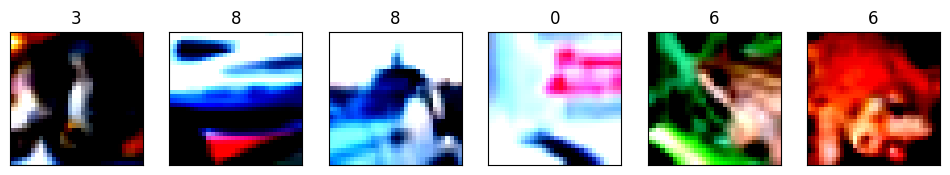

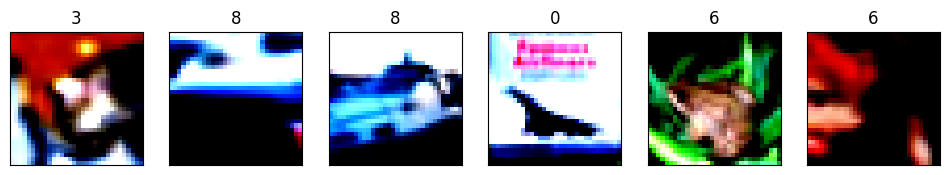

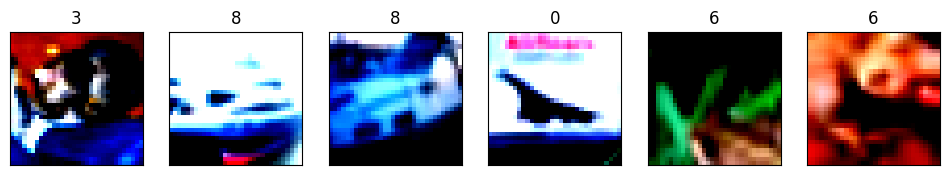

In [123]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomResizedCrop(size=32, scale=(0.08, 1.0), ratio=((0.75, 1.33)))
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

##### <span style="color:#D52B29">Shearing</span>

Shearing slants the image along the x or y axis, simulating a tilted or skewed perspective, which helps the model recognize objects from unusual viewpoints.

<span style="color:#D52B29">`RandomAffine(degrees=0, shear=20)`</span>

- Applies a shear transformation with a maximum angle of 20 degrees (no rotation in this example).

- Helps CNNs generalize to objects appearing skewed or tilted in real-world images.

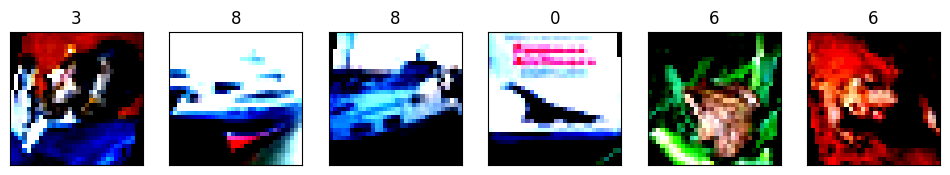

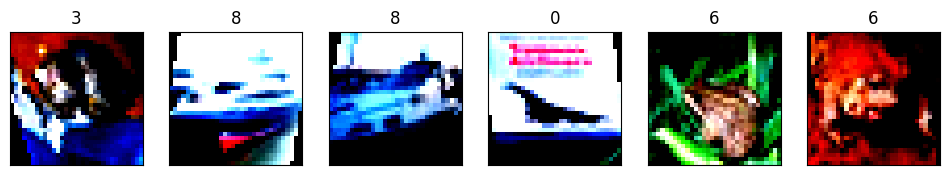

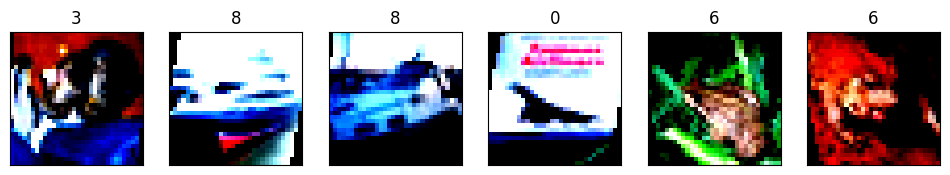

In [124]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomAffine(degrees=0, shear=20)
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

## <span style="color:#D52B29">Photometric/Color Transformations</span>

Photometric/Color transformations modify the <span style="color:#D52B29">appearance</span> of an image in terms of color, brightness, contrast, and lighting, without changing the spatial arrangement of pixels.

The goal is to help models recognize objects regardless of environmental conditions, camera settings, or lighting variations. For example, a cat remains a cat whether it appears in bright sunlight, shade, or under artificial light.

In this subsection, we will explore some of the most common photometric transformations:

- <span style="color:#D52B29">Brightness adjustment</span> – randomly changes the image brightness to simulate different lighting conditions.

- <span style="color:#D52B29">Contrast adjustment</span> – alters the contrast of the image to mimic different camera or environmental settings.

- <span style="color:#D52B29">Color jitter</span> – randomly changes hue, saturation, and color balance.

- <span style="color:#D52B29">Grayscale conversion</span> – converts the image to black and white, encouraging the model to focus on shapes and textures rather than color.

- <span style="color:#D52B29">Blurring / Sharpening</span> – simulates variations in camera focus.

By applying these transformations, CNNs become more robust to real-world variations in lighting, color, and image quality.


##### <span style="color:#D52B29">Brightness adjustment</span>

Brightness adjustment randomly changes the brightness of an image, helping the model handle different lighting conditions.

<span style="color:#D52B29">`ColorJitter(brightness=0.5)`</span>

- Brightness is changed randomly within a factor of 0.5 around the original.

- Simulates images taken under dim or bright light conditions.

It is important to note that <span style="color:#D52B29">color augmentations</span> must be applied before normalization.

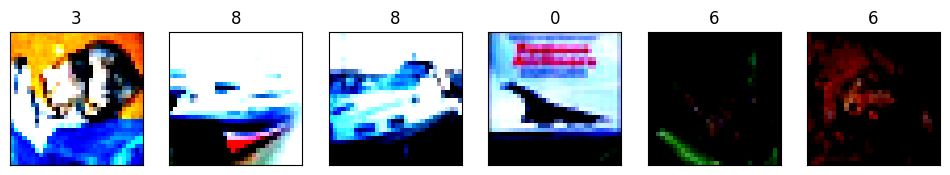

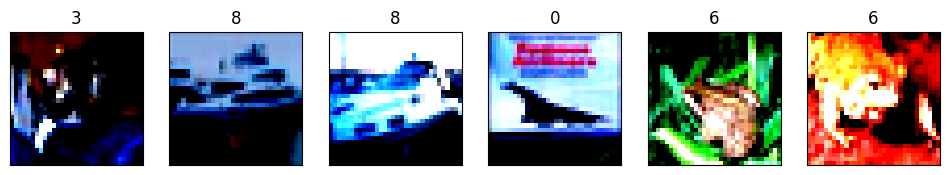

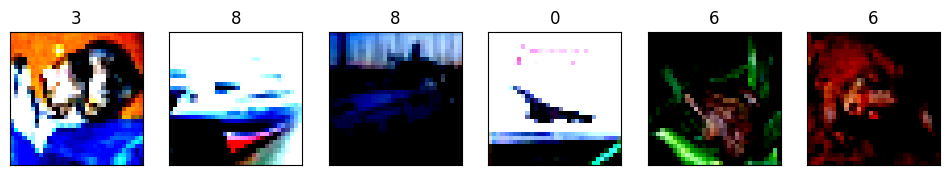

In [64]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.5),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

##### <span style="color:#D52B29">Contrast adjustment</span>

Contrast adjustment modifies the difference between light and dark regions in an image, helping the model adapt to varying environmental or camera conditions.

<span style="color:#D52B29">`ColorJitter(contrast=0.5)`</span>

- Randomly adjusts contrast by a factor of 0.5 around the original.

- Useful for images taken with different cameras or in varied lighting.

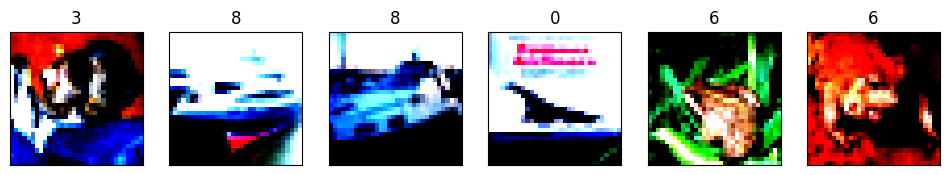

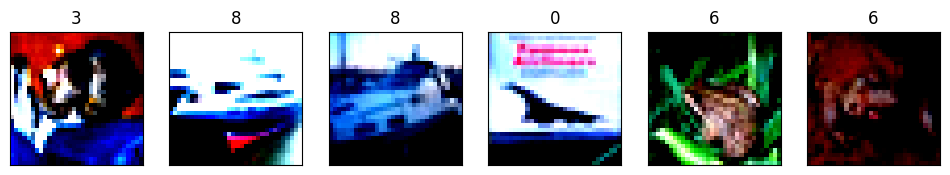

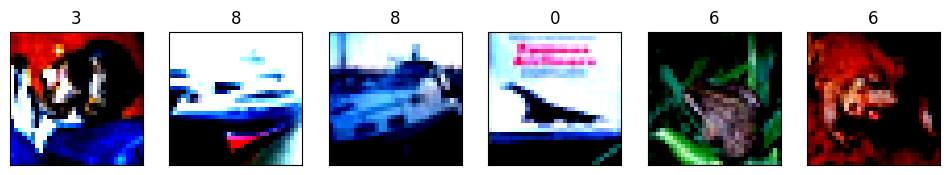

In [125]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.ColorJitter(contrast=0.5),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

##### <span style="color:#D52B29">Color Jitter</span>

Color jitter combines brightness, contrast, saturation, and hue adjustments to make the model robust to different color conditions.

<span style="color:#D52B29">`ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3)`</span>

- Randomly changes multiple color properties of the image.

- Helps the model generalize to different lighting and camera variations.

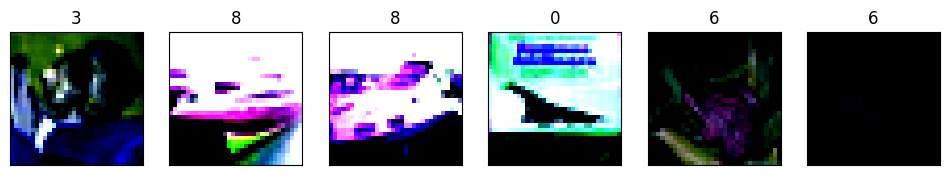

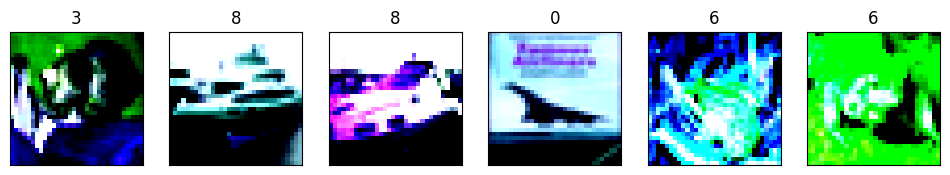

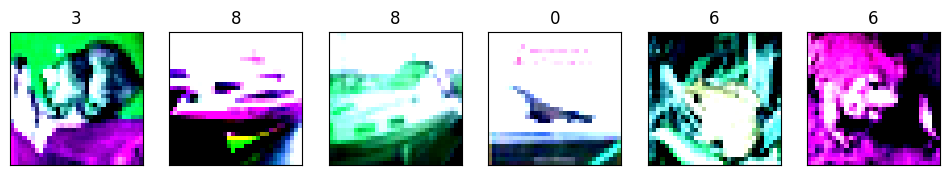

In [126]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

##### <span style="color:#D52B29">Grayscale Conversion</span>

Grayscale conversion removes color information from the image, forcing the model to rely on shapes and textures.

<span style="color:#D52B29">`RandomGrayscale(p=0.1)`</span>

- Converts the image to grayscale with probability p.

- Improves robustness when color information is unreliable or inconsistent.

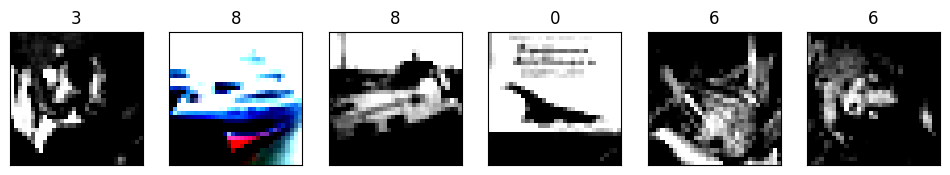

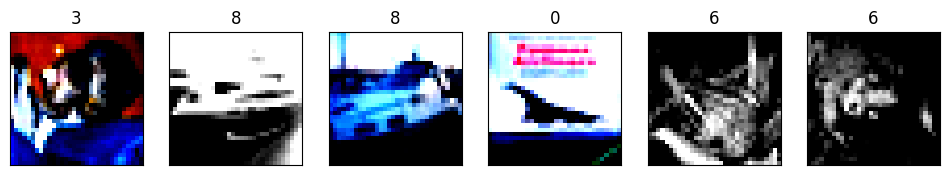

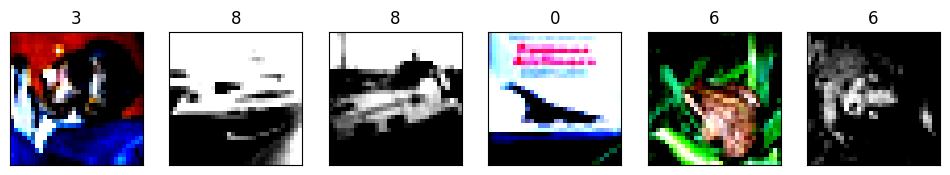

In [127]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomGrayscale(p=.5),
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

##### <span style="color:#D52B29">Blurring / Sharpening</span>

Blurring or sharpening simulates variations in camera focus or image quality.

<span style="color:#D52B29">`GaussianBlur(kernel_size=(3,3), sigma=(0.1,2.0))`</span>

- Applies a Gaussian blur with a variable kernel size and standard deviation.

- Helps the model handle slightly out-of-focus or noisy images.

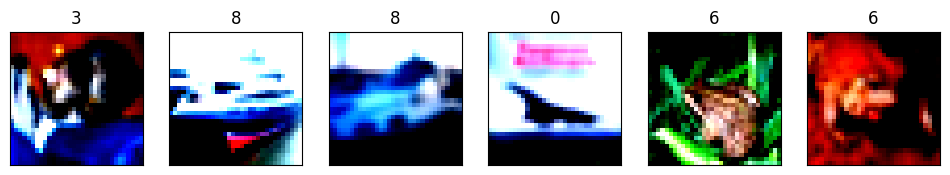

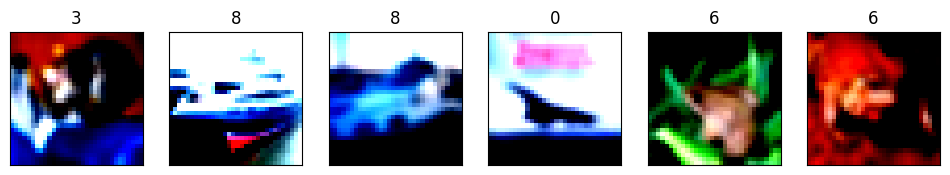

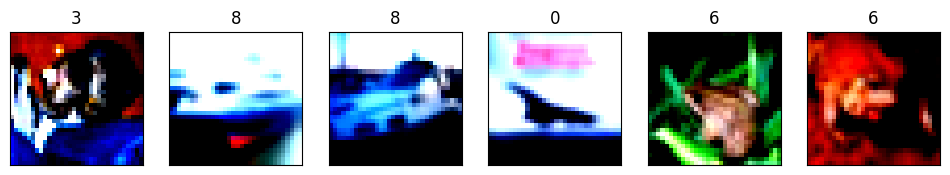

In [128]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1,2.0)),
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

## <span style="color:#D52B29">Advanced / Mixing-based Methods</span>

Advanced augmentation strategies go beyond modifying a single image by combining, occluding, or blending multiple images. These techniques help models learn <span style="color:#D52B29">more robust and generalized features</span>, especially when training datasets are limited or when objects may be partially hidden or appear in complex contexts.

The goal is to expose CNNs to <span>challenging variations</span> that are difficult to simulate with basic geometric or photometric transformations. By doing so, models become better at handling real-world scenarios where objects may overlap, be partially occluded, or appear alongside different backgrounds.

In this subsection, we will explore some of the most common advanced strategies:

- <span style="color:#D52B29">CutOut</span> – randomly removes patches of an image to simulate occlusions.  

- <span style="color:#D52B29">MixUp</span> – blends two images together to create new samples and smooth decision boundaries.  

- <span style="color:#D52B29">CutMix</span> – replaces a patch of one image with a patch from another, combining context from multiple images.

By applying these strategies, CNNs can focus on the <span>most relevant features</span> and become more robust to <span>occlusions, overlapping objects, and complex real-world situations</span>.

##### <span style="color:#D52B29">CutOut</span>

CutOut randomly removes a rectangular patch from an image, simulating occlusion and forcing the model to focus on other visible parts.

In PyTorch, CutOut can be implemented with custom transforms or using libraries like <span style="color:#D52B29">torchvision.transforms.v2</span>:

<span style="color:#D52B29">`RandomErasing(scale = (0.02, 0.33), ratio=(0.3, 0.3)`</span>

- scale defines the range of proportion of erased area against input image.
- ratio defines the range of aspect ratio of erased area.

- Improves model robustness to partially hidden objects.


In [129]:
from torchvision.transforms import v2 as transforms_v2

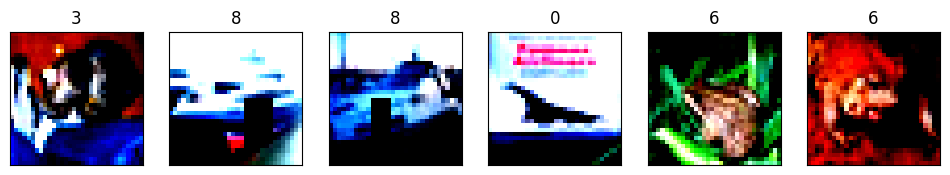

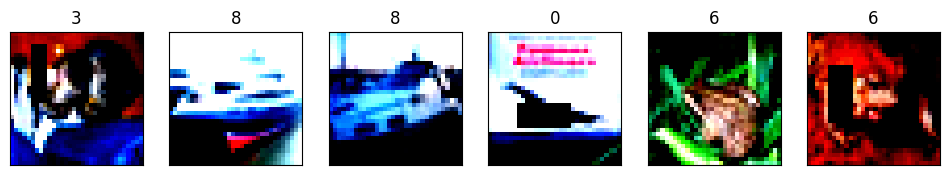

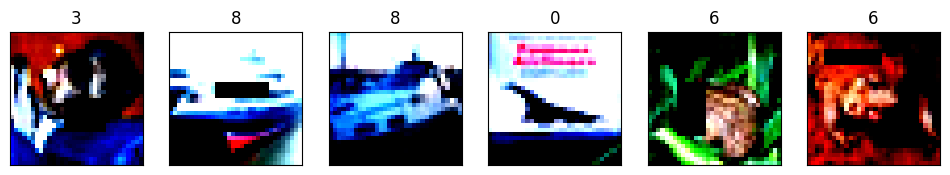

In [130]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms_v2.RandomErasing(p=.5, scale= (0.05, 0.1)),
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

show_batch(dl, n_cols=6)

##### <span style="color:#D52B29">MixUp</span>

MixUp blends two images and their labels, encouraging the model to learn smoother decision boundaries.

In PyTorch, MixUp can be implemented during the training loop:

<span style="color:#D52B29">`mixed_x = λ * x1 + (1-λ) * x2`</span>

<span style="color:#D52B29">`mixed_y = λ * y1 + (1-λ) * y2`</span>

`λ` is sampled from a Beta distribution.

Helps the model generalize better by learning from interpolated samples.

It is important to note that <span style="color:#D52B29">augmentations requiring information from two or more elements of the batch</span> are applied directly at the batch level.

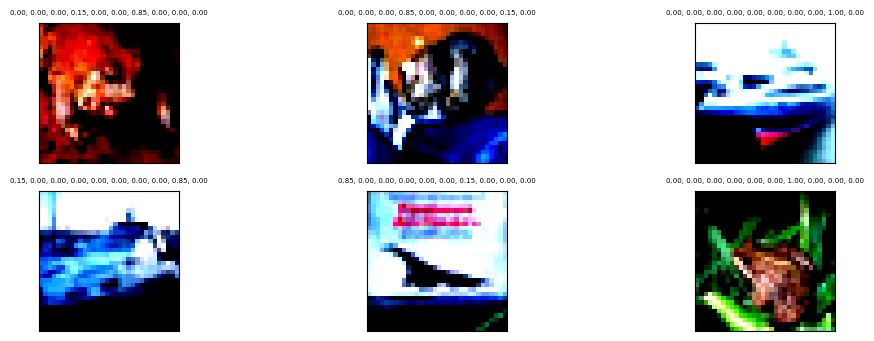

In [133]:
# In the case of CutMix and MixOut, they are applied to the batch as a whole, not to each individual element.

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

mixup = transforms_v2.MixUp(num_classes=len(ds.classes))

n_cols = 3
        
data, target = next(iter(dl)) # Get the batch

data, target = mixup(data, target)

bs = data.shape[0]
n_rows = int(np.ceil(bs / n_cols))

f, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*2))
ax = ax.ravel()
for i in range(bs):
    ax[i].imshow(np.clip(data[i].permute(1,2, 0), 0, 1))
    ax[i].set_title(', '.join([f'{e:.2f}' for e in target[i].tolist()]), fontsize=5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

for i in range(bs, n_rows*n_cols):
    f.delaxes(ax[i])

##### <span style="color:#D52B29">CutMix</span>

CutMix replaces a patch of one image with a patch from another image, combining content from multiple images and their labels.

In PyTorch, CutMix can be applied during training:

<span style="color:#D52B29">`x = x1.copy()`</span>

<span style="color:#D52B29">`x[:, y1:y2, x1:x2] = x2[:, y1:y2, x1:x2]`</span>

<span style="color:#D52B29">`y = λ * y1 + (1-λ) * y2`</span>

The patch size and location are sampled randomly.

Encourages the model to learn from multiple contexts within a single image.

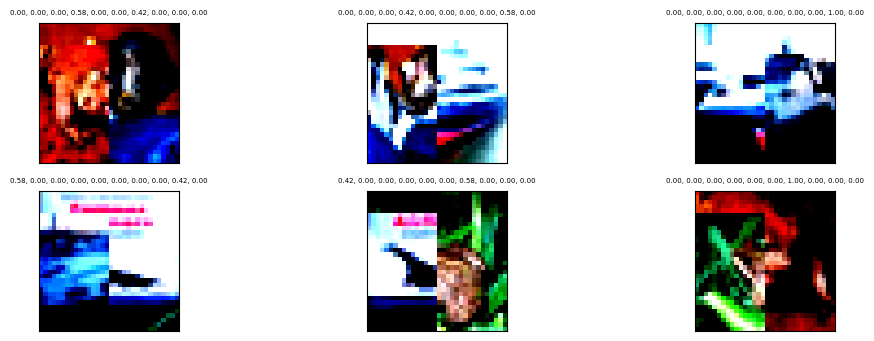

In [134]:
# In the case of CutMix and MixOut, they are applied to the batch as a whole, not to each individual element.
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 

ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
ds.data = ds.data[:6]
ds.targets = ds.targets[:6]

dl = DataLoader(ds, batch_size=16)

cutmix = transforms_v2.CutMix(num_classes=len(ds.classes))

n_cols = 3
        
data, target = next(iter(dl))

data, target = cutmix(data, target)

bs = data.shape[0]
n_rows = int(np.ceil(bs / n_cols))

f, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*2))
ax = ax.ravel()
for i in range(bs):
    ax[i].imshow(np.clip(data[i].permute(1,2, 0), 0, 1))
    ax[i].set_title(', '.join([f'{e:.2f}' for e in target[i].tolist()]), fontsize=5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

for i in range(bs, n_rows*n_cols):
    f.delaxes(ax[i])



## <span style="color:#D52B29">Summary</span>

In this exercise, you have learned how to apply a variety of <span style="color:#D52B29">data augmentation techniques</span> to improve the robustness and generalization of convolutional neural networks:

- <span style="color:#D52B29">Geometric transformations</span> – flipping, rotation, translation, cropping, resizing, and shearing to make models invariant to object orientation, position, and perspective.

- <span style="color:#D52B29">Photometric / color transformations</span> – brightness, contrast, hue/saturation adjustments, grayscale conversion, and blurring/sharpening to simulate different lighting and camera conditions.

- <span style="color:#D52B29">Advanced / mixing-based strategies</span> – CutOut, MixUp, and CutMix to expose models to occlusions, overlapping objects, and combined contexts, encouraging learning of more generalized features.

By experimenting with these transformations, you have seen how augmented data can:

- Reduce overfitting and improve model generalization.  
- Simulate real-world variations without collecting additional images.  
- Help CNNs focus on relevant features, even under challenging scenarios.  

These techniques are essential for building <span style="color:#D52B29">robust computer vision models</span> that perform well in diverse and unpredictable real-world conditions.